<a href="https://colab.research.google.com/github/manasuii/PINNS-MiniProjects/blob/main/PINN_Ball_trajectory.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
#Physical parameters
g=9.8
h0=1.0
v0=10.0

def true_solution(t):
  return h0+v0*t-0.5*g*(t**2)


#generate some time points
t_min,t_max=0,2.0
N_data=10
t_data=np.linspace(t_min,t_max,N_data)

#generate synthetic "experimental" heights with noise
np.random.seed(0)
noise_level=0.7
h_data_exact=true_solution(t_data)
h_data_noisy=h_data_exact+noise_level*np.random.randn(N_data)

#convert to pytorch tensors
t_data_tensor=torch.tensor(t_data,dtype=torch.float32).view(-1,1)
h_data_tensor=torch.tensor(h_data_noisy,dtype=torch.float32).view(-1,1)


In [ ]:
class PINN(nn.Module):
  def __init__(self,n_hidden=20):
    super(PINN,self).__init__()
    #A simple MLP with 2 hidden layers

    self.net=nn.Sequential(
        nn.Linear(1,n_hidden),
        nn.Tanh(),
        nn.Linear(n_hidden,n_hidden),
        nn.Tanh(),
        nn.Linear(n_hidden,1)

    )

  def forward(self,t):
      return self.net(t)

model=PINN(n_hidden=20)





In [ ]:
# Helper for automatic differentiation
def derivative(y, x):
    """Computes the derivative of y with respect to x."""
    # The essential part: sets 'create_graph=True' to allow backprop
    # through the gradient calculation itself (needed for 2nd deriv).
    return torch.autograd.grad(
        y, x,
        grad_outputs=torch.ones_like(y),
        retain_graph=True,
        create_graph=True
    )[0]

In [ ]:
#define the loss component(PINN)

def physics_loss(model,t):
  """
  compare d(h_pred)/dt with the known expression (v0-gt).
  """
  #t must have requires_grad= True for autgrad to work
  t.requires_grad_(True)
  h_pred=model(t)
  dh_dt_pred=derivative(h_pred,t)

  #for each t, physics says dh/dt=v0-g*t
  dh_dt_true=v0-g*t

  loss_ode=torch.mean((dh_dt_pred-dh_dt_true)**2)
  return loss_ode


def intial_condition_loss(model):
  t0=torch.zeros(1,1,dtype=torch.float32,requires_grad=False)
  h0_pred=model(t0)
  return (h0_pred-h0).pow(2).mean()


def data_loss(model,t_data,h_data):
  h_pred=model(t_data)
  return torch.mean((h_pred-h_data)**2)

In [ ]:
#training setup

optimizer=torch.optim.Adam(model.parameters(),lr=0.01)

#Hyperparameters for weighting the loss terms

lambda_data=1
lambda_ode=0.1
lambda_ic=1

#for logginig
num_epochs=2000
print_every=200





In [ ]:
# training loop

model.train()
for epoch in range(num_epochs):   # <-- use "epoch"
    optimizer.zero_grad()

    # compute losses
    l_data = data_loss(model, t_data_tensor, h_data_tensor)
    l_ode = physics_loss(model, t_data_tensor)
    l_ic  = intial_condition_loss(model)

    # combined loss
    loss = lambda_data * l_data + lambda_ode * l_ode + lambda_ic * l_ic

    # Backprop
    loss.backward()
    optimizer.step()

    # Print Progress
    if (epoch + 1) % print_every == 0:
        print(
            f"Epoch {epoch+1}/{num_epochs}, "
            f"Total Loss={loss.item():.6f}, "
            f"Data Loss={l_data.item():.6f}, "
            f"ODE Loss={l_ode.item():.6f}, "
            f"IC Loss={l_ic.item():.6f}"
        )


Epoch 200/2000, Total Loss=4.783526, Data Loss=2.808784, ODE Loss=19.609453, IC Loss=0.013797
Epoch 400/2000, Total Loss=4.728275, Data Loss=2.752536, ODE Loss=19.626963, IC Loss=0.013043
Epoch 600/2000, Total Loss=4.719394, Data Loss=2.738729, ODE Loss=19.687937, IC Loss=0.011871
Epoch 800/2000, Total Loss=4.712162, Data Loss=2.728812, ODE Loss=19.711666, IC Loss=0.012183
Epoch 1000/2000, Total Loss=0.685059, Data Loss=0.455735, ODE Loss=2.124820, IC Loss=0.016842
Epoch 1200/2000, Total Loss=0.432190, Data Loss=0.347543, ODE Loss=0.708285, IC Loss=0.013818
Epoch 1400/2000, Total Loss=0.403612, Data Loss=0.330283, ODE Loss=0.608819, IC Loss=0.012447
Epoch 1600/2000, Total Loss=0.398003, Data Loss=0.330628, ODE Loss=0.548536, IC Loss=0.012522
Epoch 1800/2000, Total Loss=0.394966, Data Loss=0.331161, ODE Loss=0.512347, IC Loss=0.012571
Epoch 2000/2000, Total Loss=0.392706, Data Loss=0.331310, ODE Loss=0.488059, IC Loss=0.012590


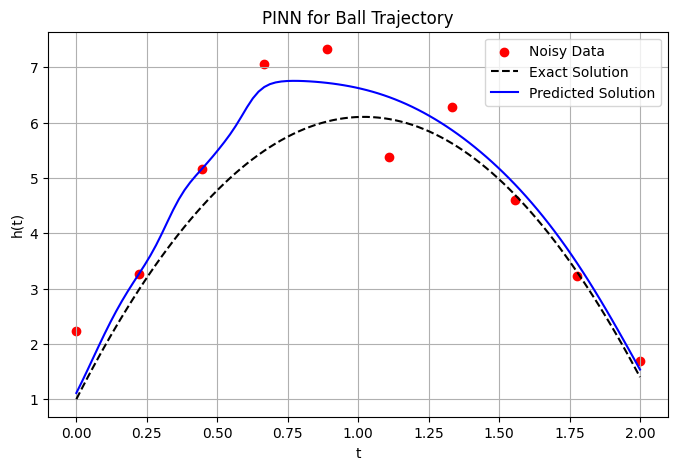

In [ ]:
from re import L
#Evaluate the trained Model

model.eval()
t_plot=np.linspace(t_min,t_max,100).reshape(-1,1).astype(np.float32)
t_plot_tensor=torch.tensor(t_plot,requires_grad=True)
h_pred_plot=model(t_plot_tensor).detach().numpy()

h_true_plot=true_solution(t_plot)

#plot the results
plt.figure(figsize=(8,5))
plt.scatter(t_data,h_data_noisy,color='red',label='Noisy Data')
plt.plot(t_plot,h_true_plot,'k--',label="Exact Solution")
plt.plot(t_plot,h_pred_plot,'b',label="Predicted Solution")
plt.xlabel('t')
plt.ylabel('h(t)')
plt.legend()
plt.title('PINN for Ball Trajectory')
plt.grid(True)
plt.show()
